In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle

In [ ]:
!echo '{"username":"joicejoseph","key":"814cbafa4e3b6bc93985de2dbb812a48"}' > /root/.kaggle/kaggle.json

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d nikhilpandey360/chest-xray-masks-and-labels

100% 9.57G/9.58G [03:20<00:00, 65.8MB/s]
100% 9.58G/9.58G [03:20<00:00, 51.2MB/s]


In [ ]:
!unzip ./*.zip  && rm *.zip

In [ ]:
import numpy as np
import os
import random
import pandas as pd
from tqdm import tqdm

import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

INSPECTING THE DATA

images

    'CHNCXR_0242_0.png'
    'MCUCXR_0017_0.png'

mask

    'MCUCXR_0017_0.png'
    'CHNCXR_0337_1_mask.png'


In [ ]:
image_path_train = './Lung Segmentation/CXR_png/'
mask_path_train = './Lung Segmentation/masks/'
image_path_test = './Lung Segmentation/test/' 

In [ ]:
# we have 704 masks but 800 images. Hence we are going to
# make a 1-1 correspondance from mask to images, not the usual other way
images = os.listdir(image_path_train)
mask = os.listdir(mask_path_train)
mask = [filename.split(".png")[0] for filename in mask]
image_file_name = [filename.split("_mask")[0] for filename in mask]
print(len(image_file_name), len(mask))

704 704


In [ ]:
check = [i for i in mask if "mask" in i]
print("Total masks that have modified name:", len(check))

Total masks that have modified name: 566


In [ ]:
testing_files = set(os.listdir(image_path_train)) & set(os.listdir(mask_path_train))
training_files = check

In [ ]:
def getData(X_shape, flag = "MONT"):
    im_array = []
    mask_array = []
    shape = (X_shape, X_shape)
    # X_shape = image_size
    if flag == "MONT":
        for i in tqdm(testing_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i))
            im = cv2.resize(im, shape)[:, :, 0]
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    
    if flag == "SHEN":
        for i in tqdm(training_files): 
            
            # im.shape = (X_shape, X_shape, 1)
            im = cv2.imread(os.path.join(image_path_train, i.split("_mask")[0] + ".png"))
            im = cv2.resize(im, shape)[:, :, 0]
            im = cv2.equalizeHist(im)
            # mask.shape = (X_shape, X_shape, 1)
            mask = cv2.imread(os.path.join(mask_path_train, i + ".png"))
            mask = cv2.resize(mask, shape)[:, :, 0]
            
            im_array.append(im)
            mask_array.append(mask)
    # return list
    return im_array, mask_array

In [ ]:
def get_test(X_shape, n_samples = 10):
    im_array = []
    shape = (X_shape, X_shape)
    test_files = random.choices(list(os.listdir(image_path_test)), k=n_samples)
    for i in tqdm(test_files):
        im = cv2.imread(os.path.join(image_path_test, i))
        im = cv2.resize(im, shape)[:, :, 0]
        im = cv2.equalizeHist(im)
        im_array.append(im)
    return im_array

In [ ]:
dim, n_samples = 512, 10 

image_shen, mask_shen = getData(dim, flag = "SHEN")
image_mont, mask_mont = getData(dim, flag = "MONT")
X_test = get_test(dim, n_samples = n_samples)

100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


In [ ]:
image_shen = np.array(image_shen).reshape(len(image_shen), dim, dim, 1)
mask_shen = np.array(mask_shen).reshape(len(mask_shen), dim, dim, 1)

image_mont = np.array(image_mont).reshape(len(image_mont), dim, dim, 1)
mask_mont = np.array(mask_mont).reshape(len(mask_mont), dim, dim, 1)

X_test = np.array(X_test).reshape(len(X_test), dim, dim, 1)

In [ ]:
print(image_shen.shape, mask_shen.shape)
print(image_mont.shape, mask_mont.shape)
print(X_test.shape)

(566, 512, 512, 1) (566, 512, 512, 1)
(138, 512, 512, 1) (138, 512, 512, 1)
(10, 512, 512, 1)


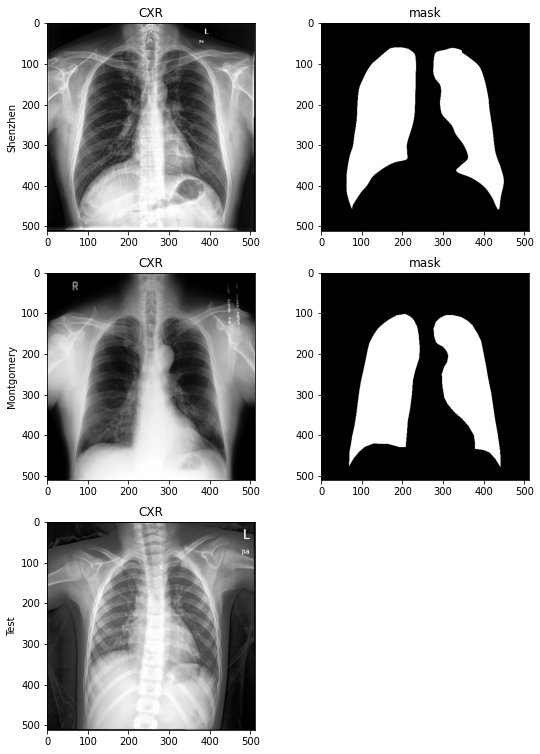

In [ ]:

i = 5
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(9, 13))
axs[0, 0].imshow(np.squeeze(image_shen[i]), cmap='gray')
axs[0, 1].imshow(np.squeeze(mask_shen[i]), cmap='gray')
axs[0, 0].set_ylabel('Shenzhen')

axs[1, 0].imshow(np.squeeze(image_mont[i]), cmap='gray')
axs[1, 1].imshow(np.squeeze(mask_mont[i]), cmap='gray')
axs[1, 0].set_ylabel('Montgomery')

axs[2, 0].imshow(np.squeeze(X_test[i]), cmap='gray')
axs[2, 0].set_ylabel('Test')

axs[0, 0].set_title('CXR')
axs[1, 0].set_title('CXR')
axs[2, 0].set_title('CXR')

axs[0, 1].set_title('mask')
axs[1, 1].set_title('mask')

fig.delaxes(axs[2, 1])





Both the datasets look good. Combining and using them as a unified dataset

In [ ]:
images = np.concatenate((image_shen, image_mont), axis=0)
masks  = np.concatenate((mask_shen, mask_mont), axis=0)

print(images.shape, masks.shape)

(704, 512, 512, 1) (704, 512, 512, 1)


Splitting the datsaets into train and val

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split((images - 127.0) / 127.0, 
                                                  (masks > 127).astype(np.float32), 
                                                  test_size = 0.15, 
                                                  random_state = 42)
X_testNorm = (X_test - 127.0) / 127.0

Defining Metrics

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred) 

Defining UNET

In [ ]:
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [ ]:
model = unet(input_size=(512,512,1))
model.compile(optimizer=Adam(lr=2e-4), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 512, 512, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.25, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
h = model.fit(X_train, Y_train, 
                validation_data=(X_val, Y_val), 
                batch_size=16, epochs=50,
                callbacks= callbacks_list)

Epoch 1/50
38/38 [==============================] - ETA: 0s - loss: -0.4334 - dice_coef: 0.4368 - binary_accuracy: 0.6576
Epoch 00001: val_loss improved from inf to -0.54707, saving model to cxr_reg_weights.best.hdf5
38/38 [==============================] - 117s 3s/step - loss: -0.4334 - dice_coef: 0.4368 - binary_accuracy: 0.6576 - val_loss: -0.5471 - val_dice_coef: 0.5493 - val_binary_accuracy: 0.6113 - lr: 2.0000e-04
Epoch 2/50
38/38 [==============================] - ETA: 0s - loss: -0.5750 - dice_coef: 0.5752 - binary_accuracy: 0.6684
Epoch 00002: val_loss improved from -0.54707 to -0.56825, saving model to cxr_reg_weights.best.hdf5
38/38 [==============================] - 92s 2s/step - loss: -0.5750 - dice_coef: 0.5752 - binary_accuracy: 0.6684 - val_loss: -0.5683 - val_dice_coef: 0.5716 - val_binary_accuracy: 0.6682 - lr: 2.0000e-04
Epoch 3/50
38/38 [==============================] - ETA: 0s - loss: -0.6195 - dice_coef: 0.6188 - binary_accuracy: 0.7281
Epoch 00003: val_loss impr

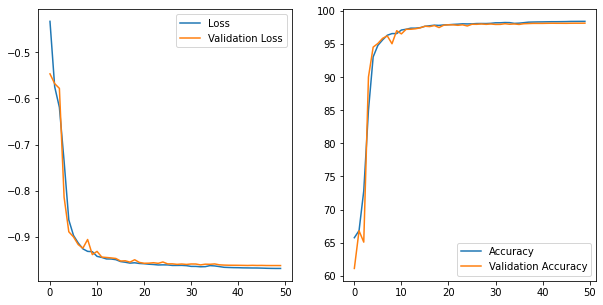

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(h.history['loss'], '-', label = 'Loss')
ax1.plot(h.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100 * np.array(h.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100 * np.array(h.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend();

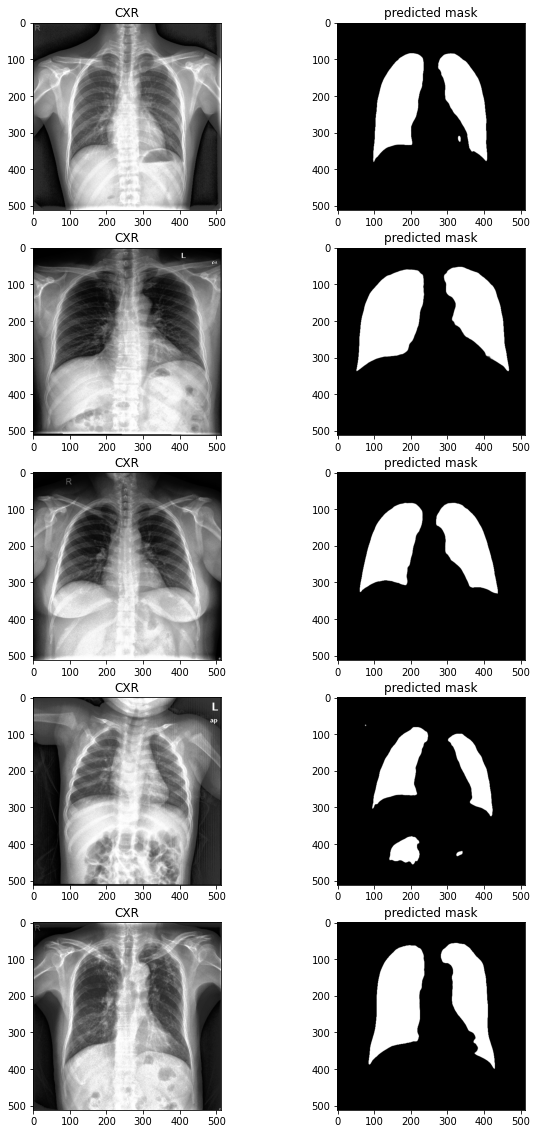

In [ ]:
preds = model.predict(X_testNorm)

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))

for i in range(5):
    for j in range(2):
        if j != 1:
            axs[i, j].imshow(np.squeeze(X_testNorm[i]), cmap='gray')
            axs[i, j].set_title('CXR')
        else:
            axs[i, j].imshow(np.squeeze(preds[i]), cmap='gray')
            axs[i, j].set_title('predicted mask')